<a href="https://colab.research.google.com/github/jhj1111/DAGM2007_ws/blob/main/DAGM2007_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📊 Food101 이미지 분류 프로젝트 (ResNet 활용)

## 🔎 개요
이 노트북은 Food101 데이터셋을 이용해 이미지 분류를 수행하는 프로젝트입니다.
ResNet18/ResNet50을 사용해 학습, 검증, 평가까지 진행합니다.

## 🛠️ 주요 작업
1. DatasetManager: 데이터셋 로드 및 분할
2. ModelTrainer: 학습 및 검증
3. Evaluator: 테스트 데이터 평가
4. Loss 그래프 시각화
5. GitHub 연동 방법

# import

In [ ]:
# 기본 라이브러리 & PyTorch 모듈 임포트
import torch, random
from torch.utils.data import DataLoader, Subset, WeightedRandomSampler
from torchvision import datasets, transforms, models
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import torchvision.transforms.functional as F
import os, cv2, glob, shutil
import zipfile
import ipywidgets as widgets
from IPython.display import display, clear_output
from sklearn.model_selection import train_test_split
from torchvision.datasets import ImageFolder
from torchvision.datasets.folder import default_loader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.metrics import classification_report

base_dir = '/content'
# base_dir = r'C:\Users\HP\Documents\code_ws\vision_ws\DAGM2007'

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.7' (you have '2.0.6'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


# DAGM 2007 dataset 다운로드

In [ ]:
os.chdir(base_dir)

for i in range(1,6):
  zip_name = f'Class{i}.zip'
  zip_name_def = f'Class{i}_def.zip'
  url = f'https://conferences.mpi-inf.mpg.de/dagm/2007/Class{i}.zip'
  url_def = f'https://conferences.mpi-inf.mpg.de/dagm/2007/Class{i}_def.zip'
  if not os.path.exists(zip_name):
    !wget $url
    # wget.download(url)
  if not os.path.exists(zip_name_def):
    !wget $url_def
    # wget.download(url_def)

--2025-05-16 14:06:01--  https://conferences.mpi-inf.mpg.de/dagm/2007/Class1.zip
Resolving conferences.mpi-inf.mpg.de (conferences.mpi-inf.mpg.de)... 139.19.206.169
Connecting to conferences.mpi-inf.mpg.de (conferences.mpi-inf.mpg.de)|139.19.206.169|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 231243312 (221M) [application/zip]
Saving to: ‘Class1.zip’

Class1.zip          100%[===================>] 220.53M  5.58MB/s    in 21s     

2025-05-16 14:06:23 (10.3 MB/s) - ‘Class1.zip’ saved [231243312/231243312]

--2025-05-16 14:06:23--  https://conferences.mpi-inf.mpg.de/dagm/2007/Class1_def.zip
Resolving conferences.mpi-inf.mpg.de (conferences.mpi-inf.mpg.de)... 139.19.206.169
Connecting to conferences.mpi-inf.mpg.de (conferences.mpi-inf.mpg.de)|139.19.206.169|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34556484 (33M) [application/zip]
Saving to: ‘Class1_def.zip’

Class1_def.zip      100%[===================>]  32.96M  11.8MB/s    i

In [ ]:
os.chdir(base_dir)

zipfiles = glob.glob('*.zip')
for zipfile in zipfiles:
  dir_name = zipfile.replace('.zip', '')
  if not os.path.exists(dir_name):
    !unzip $zipfile
    # shutil.unpack_archive(zipfile)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: Class5/797.png          
  inflating: Class5/798.png          
  inflating: Class5/799.png          
  inflating: Class5/8.png            
  inflating: Class5/80.png           
  inflating: Class5/800.png          
  inflating: Class5/801.png          
  inflating: Class5/802.png          
  inflating: Class5/803.png          
  inflating: Class5/804.png          
  inflating: Class5/805.png          
  inflating: Class5/806.png          
  inflating: Class5/807.png          
  inflating: Class5/808.png          
  inflating: Class5/809.png          
  inflating: Class5/81.png           
  inflating: Class5/810.png          
  inflating: Class5/811.png          
  inflating: Class5/812.png          
  inflating: Class5/813.png          
  inflating: Class5/814.png          
  inflating: Class5/815.png          
  inflating: Class5/816.png          
  inflating: Class5/817.png          
  inflating: Class5/818.png          
  inflating: C

# Class 선언

## AlbDataset
- dataset iteration 생성

In [ ]:
class AlbDataset(ImageFolder):
    def __init__(self, root, transform):
        super().__init__(root)
        self.alb_transform = transform

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        image = default_loader(path)
        image = self.alb_transform(image=np.array(image))['image']
        return image, label

## 📊 Dataset Class - Food101DatasetManager
Food101DatasetManager 클래스는 데이터셋을 로드하고, train/val/test로 분리하여 DataLoader를 생성하는 역할을 합니다.

In [ ]:
class Food101DatasetManager:
    """
    Food101DatasetManager:
    - Food101 데이터셋을 불러오고
    - StratifiedShuffleSplit로 train/val 분리
    - DataLoader로 반환하는 클래스
    """
    def __init__(self, data_dir='./data', val_ratio=0.1, batch_size=32, num_workers=2, resize=(224, 224), normalize1=[0.485, 0.456, 0.406], normalize2=[0.229, 0.224, 0.225]):
        self.data_dir = data_dir
        self.val_ratio = val_ratio
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.transform = transforms.Compose([
            transforms.Resize(resize),
            transforms.ToTensor(),
            transforms.Normalize(normalize1, normalize2)
        ])

    def load(self, dataset='Food101', train_set=None, val_set=None, testset=None):
      if dataset == 'Food101':
        full_trainset = datasets.Food101(root=self.data_dir, split='train', transform=self.transform, download=True)
        testset = datasets.Food101(root=self.data_dir, split='test', transform=self.transform, download=True)
        classes = full_trainset.classes

        labels = [full_trainset[i][1] for i in range(len(full_trainset))]
        sss = StratifiedShuffleSplit(n_splits=1, test_size=self.val_ratio, random_state=42)
        train_idx, val_idx = next(sss.split(np.zeros(len(labels)), labels))

        train_set = Subset(full_trainset, train_idx)
        val_set = Subset(full_trainset, val_idx)

        train_loader = DataLoader(train_set, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers)
        val_loader = DataLoader(val_set, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers)
        test_loader = DataLoader(testset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers)

      elif dataset == 'DAGM2007' and train_set is not None and val_set is not None and testset is not None:
        classes = ['normal', 'defect']
        train_loader = DataLoader(train_set, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers)
        val_loader = DataLoader(val_set, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers)
        test_loader = DataLoader(testset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers)

      return train_loader, val_loader, test_loader, classes

## 🏋️ Trainer Class - Food101ModelTrainer
모델을 학습하고 검증하는 Trainer 클래스입니다.
ResNet18/ResNet50 선택 가능, optimizer와 loss 정의 포함.

In [ ]:
class Food101ModelTrainer:
    """
    Food101ModelTrainer:
    - 모델 생성 (ResNet18/50)
    - Optimizer & Loss 설정
    - Train & Validation 루프 실행
    """

    def __init__(self, train_loader, val_loader, classes, model_name='resnet18', lr=0.001, optimizer_type='adam', device=None):
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.classes = classes
        self.device = device or ('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = self.build_model(model_name)
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = self.get_optimizer(optimizer_type, lr)
        self.train_losses = []
        self.val_losses = []

    def build_model(self, model_name):
        # 사전 학습된 ResNet 모델 로드
        model = models.resnet18(pretrained=True) if model_name == 'resnet18' else models.resnet50(pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, len(self.classes))  # Food101 클래스 수로 변경
        return model.to(self.device)

    def get_optimizer(self, optimizer_type, lr):
        if optimizer_type == 'sgd':
            return optim.SGD(self.model.parameters(), lr=lr, momentum=0.9)
        return optim.Adam(self.model.parameters(), lr=lr)

    def train_epoch(self):
        self.model.train()
        total_loss, correct = 0.0, 0
        for x, y in self.train_loader:
            x, y = x.to(self.device), y.to(self.device)
            self.optimizer.zero_grad()
            out = self.model(x)
            loss = self.criterion(out, y)
            loss.backward()
            self.optimizer.step()
            total_loss += loss.item() * x.size(0)
            correct += (out.argmax(1) == y).sum().item()
        return total_loss / len(self.train_loader.dataset), correct / len(self.train_loader.dataset)

    def evaluate(self):
        self.model.eval()
        total_loss, correct = 0.0, 0
        all_preds, all_labels = [], []
        with torch.no_grad():
            for x, y in self.val_loader:
                x, y = x.to(self.device), y.to(self.device)
                out = self.model(x)
                loss = self.criterion(out, y)
                total_loss += loss.item() * x.size(0)
                correct += (out.argmax(1) == y).sum().item()
                all_preds.extend(out.argmax(1).cpu().numpy())
                all_labels.extend(y.cpu().numpy())
        return total_loss / len(self.val_loader.dataset), correct / len(self.val_loader.dataset), all_preds, all_labels

    def train(self, epochs):
        for epoch in range(epochs):
            tr_loss, tr_acc = self.train_epoch()
            val_loss, val_acc, _, _ = self.evaluate()
            self.train_losses.append(tr_loss)
            self.val_losses.append(val_loss)
            print(f"Epoch {epoch+1}: Train Loss={tr_loss:.4f}, Train Acc={tr_acc:.4f}, Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}")


## 🧪 Evaluator Class - Food101Evaluator
테스트셋을 이용한 평가 클래스입니다.

In [ ]:
class Food101Evaluator:
    """
    Food101Evaluator:
    - 테스트 데이터셋을 이용해 최종 정확도 측정
    - Confusion Matrix 시각화 가능 (추가로 확장 가능)
    """
    def __init__(self, model, test_loader, classes, device):
        self.model = model
        self.test_loader = test_loader
        self.classes = classes
        self.device = device

    def evaluate(self):
        self.model.eval()
        criterion = nn.CrossEntropyLoss()
        total_loss, correct = 0.0, 0
        all_preds, all_labels = [], []
        with torch.no_grad():
            for x, y in self.test_loader:
                x, y = x.to(self.device), y.to(self.device)
                out = self.model(x)
                loss = criterion(out, y)
                total_loss += loss.item() * x.size(0)
                correct += (out.argmax(1) == y).sum().item()
                all_preds.extend(out.argmax(1).cpu().numpy())
                all_labels.extend(y.cpu().numpy())
        test_acc = correct / len(self.test_loader.dataset)
        print(f"Test Accuracy: {test_acc:.4f}")
        return all_preds, all_labels


## Visual Class

In [ ]:
class Food101Visualizer:
    def __init__(self, classes):
        self.classes = classes
        self.mean = torch.tensor([0.485, 0.456, 0.406])
        self.std = torch.tensor([0.229, 0.224, 0.225])

    def denormalize(self, tensor):
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor

    def plot_confusion_matrix(self, y_true, y_pred, selected_classes=None):
        cm = confusion_matrix(y_true, y_pred)
        if selected_classes:
            indices = [self.classes.index(cls) for cls in selected_classes]
            cm = cm[np.ix_(indices, indices)]
            labels = selected_classes
        else:
            labels = ['Correct', 'Incorrect']
            cm = np.array([[np.trace(cm), cm.sum() - np.trace(cm)], [0, 0]])
        sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()

    def plot_sample_predictions(self, model, dataset, device, num_images=5):
        model.eval()
        indices = random.sample(range(len(dataset)), num_images)
        plt.figure(figsize=(15, 3 * num_images))
        for i, idx in enumerate(indices):
            image, label = dataset[idx]
            input_tensor = image.unsqueeze(0).to(device)
            with torch.no_grad():
                pred = model(input_tensor).argmax(1).item()
            img = F.to_pil_image(self.denormalize(image.clone()))
            plt.subplot(num_images, 1, i + 1)
            plt.imshow(img)
            color = 'green' if pred == label else 'red'
            plt.title(f"Predicted: {self.classes[pred]} | True: {self.classes[label]}", color=color)
            plt.axis('off')
        plt.tight_layout()
        plt.show()

# Food101 train

## 데이터셋 로드

In [ ]:
dataset = Food101DatasetManager()
train_loader, val_loader, test_loader, classes = dataset.load()

100%|██████████| 5.00G/5.00G [03:44<00:00, 22.3MB/s]


## 📉 모델 학습

### learning rate = 0.01

In [ ]:
# Trainer 내부에서 기록한 train_losses, val_losses 이용 (예시)
trainer = Food101ModelTrainer(train_loader, val_loader, classes, model_name='resnet18', lr=0.01, optimizer_type='adam')
trainer.train(epochs=5)  # 예시

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 156MB/s]


Epoch 1: Train Loss=4.5009, Train Acc=0.0285, Val Loss=4.4637, Val Acc=0.0474
Epoch 2: Train Loss=4.0289, Train Acc=0.0844, Val Loss=3.9001, Val Acc=0.1075
Epoch 3: Train Loss=3.6441, Train Acc=0.1467, Val Loss=3.6549, Val Acc=0.1506
Epoch 4: Train Loss=3.3194, Train Acc=0.2055, Val Loss=3.2677, Val Acc=0.2215
Epoch 5: Train Loss=3.0652, Train Acc=0.2554, Val Loss=3.0902, Val Acc=0.2564


#### train, validation Loss 그래프

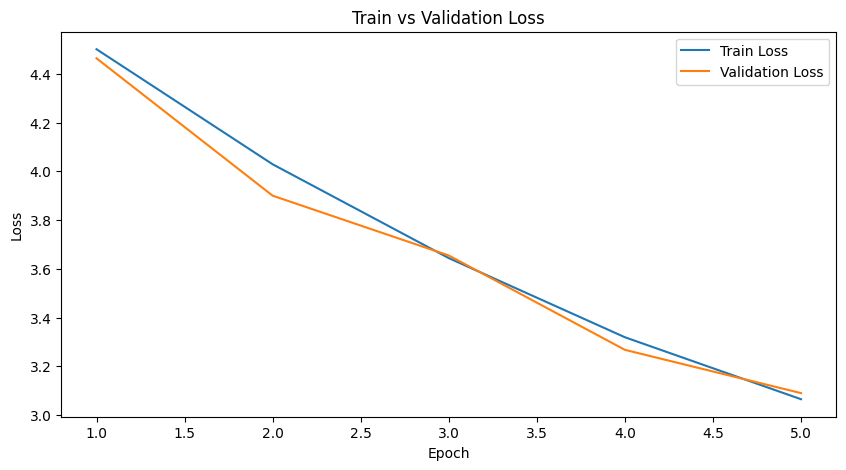

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(trainer.train_losses)+1), trainer.train_losses, label='Train Loss')
plt.plot(range(1, len(trainer.val_losses)+1), trainer.val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()
plt.show()

In [ ]:
evaluator = Food101Evaluator(trainer.model, test_loader, classes, trainer.device)
preds, labels = evaluator.evaluate()

Test Accuracy: 0.2835


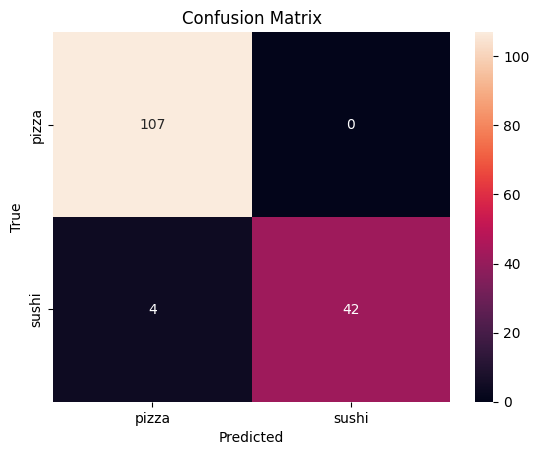

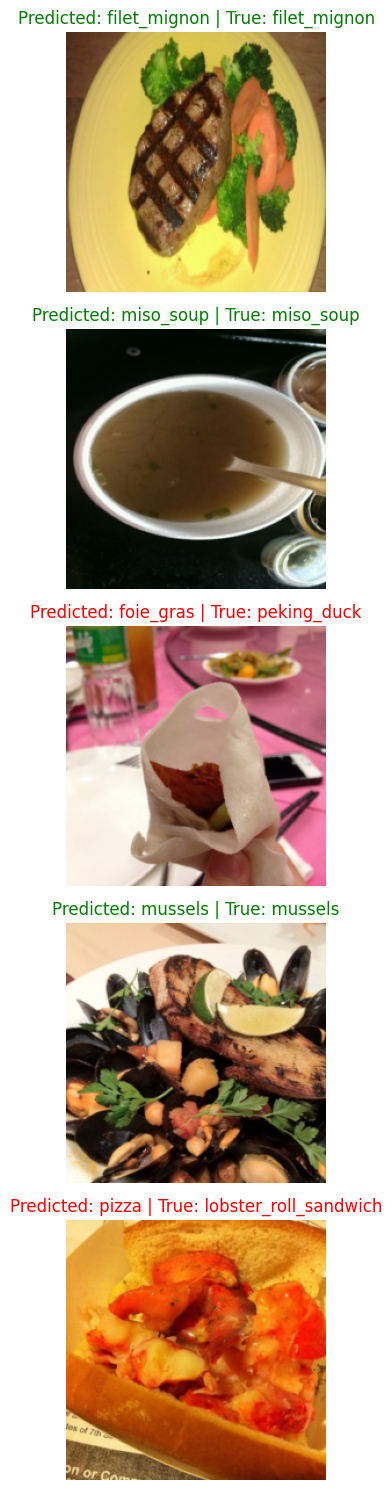

In [ ]:
visualizer = Food101Visualizer(classes)
visualizer.plot_confusion_matrix(labels, preds, selected_classes=['pizza', 'sushi'])
visualizer.plot_sample_predictions(trainer.model, test_loader.dataset, trainer.device)

### learning rate = 0.05

In [ ]:
# Trainer 내부에서 기록한 train_losses, val_losses 이용 (예시)
trainer = Food101ModelTrainer(train_loader, val_loader, classes, model_name='resnet18', lr=0.05, optimizer_type='adam')
trainer.train(epochs=5)  # 예시

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1: Train Loss=4.7165, Train Acc=0.0139, Val Loss=4.5375, Val Acc=0.0218
Epoch 2: Train Loss=4.5061, Train Acc=0.0224, Val Loss=4.4741, Val Acc=0.0217
Epoch 3: Train Loss=4.4753, Train Acc=0.0243, Val Loss=4.4858, Val Acc=0.0222
Epoch 4: Train Loss=4.4449, Train Acc=0.0236, Val Loss=4.4504, Val Acc=0.0268
Epoch 5: Train Loss=4.4202, Train Acc=0.0244, Val Loss=4.4226, Val Acc=0.0265


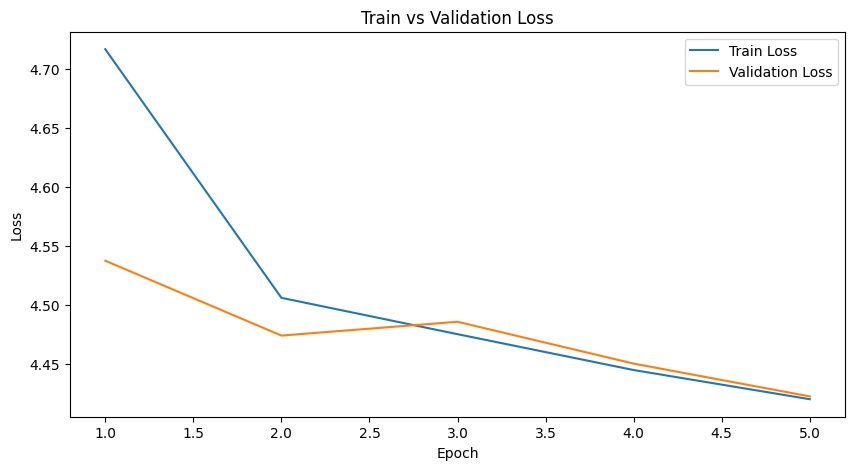

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(trainer.train_losses)+1), trainer.train_losses, label='Train Loss')
plt.plot(range(1, len(trainer.val_losses)+1), trainer.val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()
plt.show()

In [ ]:
evaluator = Food101Evaluator(trainer.model, test_loader, classes, trainer.device)
preds, labels = evaluator.evaluate()

Test Accuracy: 0.0272


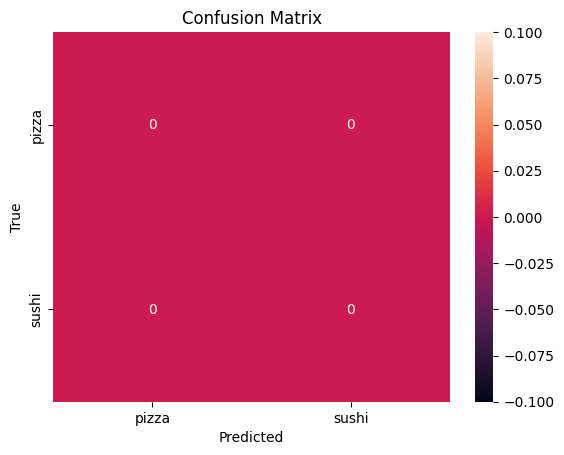

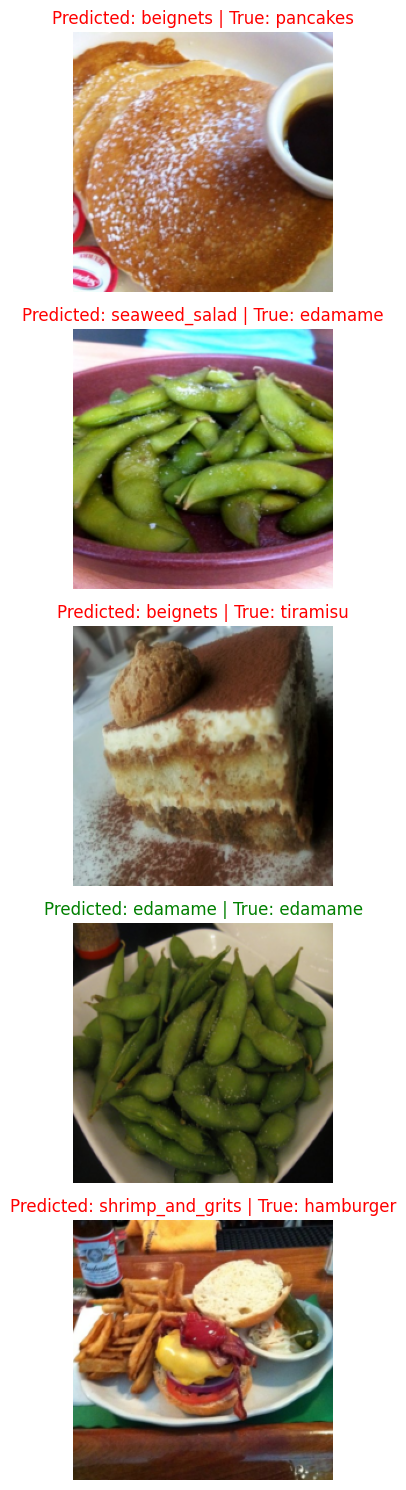

In [ ]:
visualizer = Food101Visualizer(classes)
visualizer.plot_confusion_matrix(labels, preds, selected_classes=['pizza', 'sushi'])
visualizer.plot_sample_predictions(trainer.model, test_loader.dataset, trainer.device)

# learning rate와 데이터 학습
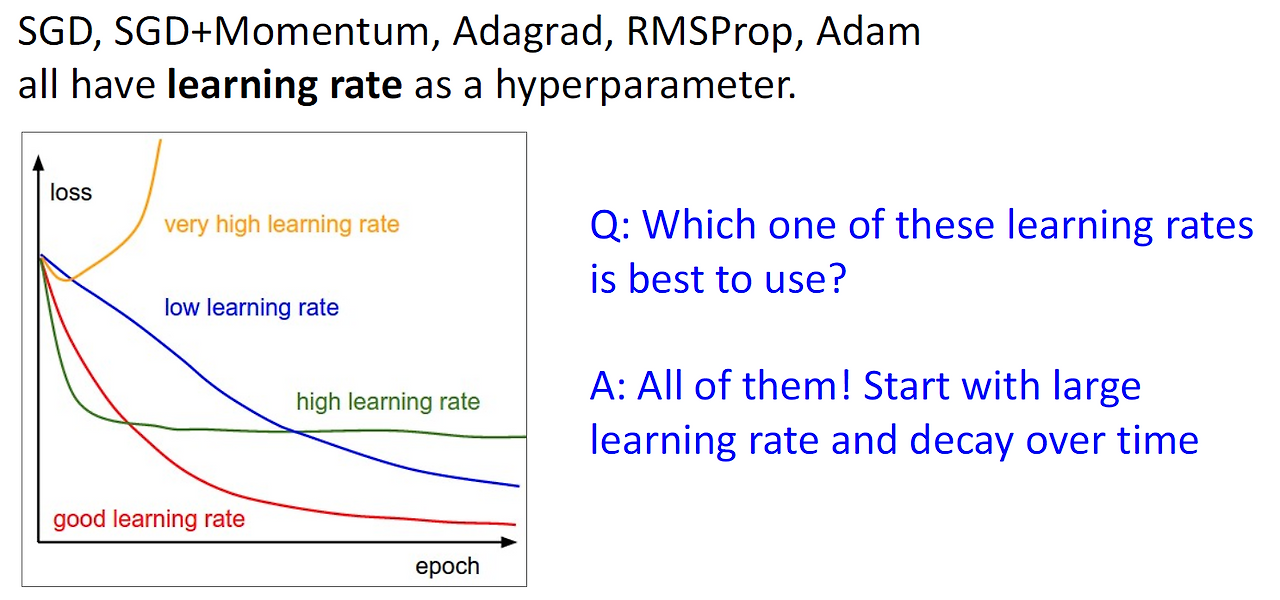

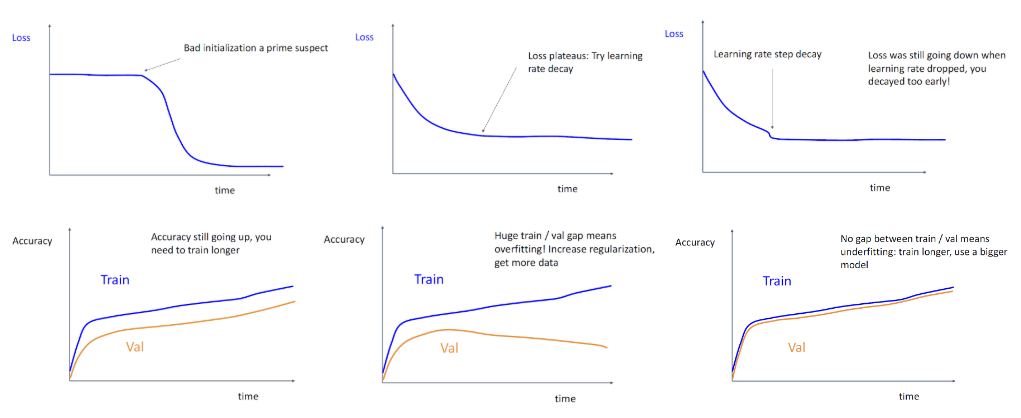

# DAGM2007 train

## Dataset load

In [ ]:
transform_train = A.Compose([
    A.Resize(224, 224),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    A.Normalize(mean=(0.5,), std=(0.5,)),
    ToTensorV2()
])


In [ ]:
transform_val = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=(0.5,), std=(0.5,)),
    ToTensorV2()
])

In [ ]:
normal_images = glob.glob("/content/Class?/*.png", recursive=True)
defect_images = glob.glob("/content/*_def/*.png", recursive=True)

# Train/Val/Test 8/1/1 Split
train_n, val_test_n = train_test_split(normal_images, test_size=0.2, random_state=42)
train_d, val_test_d = train_test_split(defect_images, test_size=0.2, random_state=42)
val_n, test_n = train_test_split(val_test_n, test_size=0.5, random_state=42)
val_d, test_d = train_test_split(val_test_d, test_size=0.5, random_state=42)

print("정상 이미지 개수 (train+val):", len(normal_images))
print("불량 이미지 개수 (train+val):", len(defect_images))

# 복사 함수
def copy_to(subset, label, files):
    target_dir = f"/content/{subset}/{label}"
    os.makedirs(target_dir, exist_ok=True)
    for f in files:
        shutil.copy(f, target_dir)

# 데이터 복사
copy_to("train", "normal", train_n)
copy_to("train", "defect", train_d)
copy_to("val", "normal", val_n)
copy_to("val", "defect", val_d)
copy_to("test", "normal", test_n)
copy_to("test", "defect", test_d)

정상 이미지 개수 (train+val): 5000
불량 이미지 개수 (train+val): 750


## 모델 학습

In [ ]:
# dataset = Food101DatasetManager()
# dataset.transform = transform_val
# train_loader, val_loader, test_loader, classes = dataset.load(dataset='DAGM2007', train_set=train_loader, val_set=val_loader, testset=test_loader)

# train_loader = AlbDataset("/content/train", transform_train)
# val_loader = AlbDataset("/content/val", transform_val)
# test_loader = AlbDataset("/content/test", transform_val)
train_loader = DataLoader(AlbDataset("/content/train", transform_train), batch_size=32, shuffle=True)
val_loader = DataLoader(AlbDataset("/content/val", transform_val), batch_size=32, shuffle=False)
test_loader = DataLoader(AlbDataset("/content/test", transform_val), batch_size=32, shuffle=False)
classes = ['normal', 'defect']

In [ ]:
dataset = Food101DatasetManager()
f_train_loader, f_val_loader, f_test_loader, classes = dataset.load()

100%|██████████| 5.00G/5.00G [04:01<00:00, 20.7MB/s]


In [ ]:
f_train_loader, f_val_loader, f_test_loader, f_classes = dataset.load()
f_classes

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [ ]:
len(f_classes)

101

### learning rate = 0.01

In [ ]:
# Trainer 내부에서 기록한 train_losses, val_losses 이용 (예시)
trainer = Food101ModelTrainer(train_loader, val_loader, classes, model_name='resnet18', lr=0.01, optimizer_type='adam')
trainer.train(epochs=5)  # 예시

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1: Train Loss=0.8470, Train Acc=0.8435, Val Loss=37.6764, Val Acc=0.8708
Epoch 2: Train Loss=0.4991, Train Acc=0.8643, Val Loss=0.3802, Val Acc=0.8708
Epoch 3: Train Loss=0.4641, Train Acc=0.8652, Val Loss=0.3921, Val Acc=0.8708
Epoch 4: Train Loss=0.5226, Train Acc=0.8652, Val Loss=0.4213, Val Acc=0.8708
Epoch 5: Train Loss=0.4300, Train Acc=0.8670, Val Loss=0.3871, Val Acc=0.8708


#### train, validation Loss 그래프

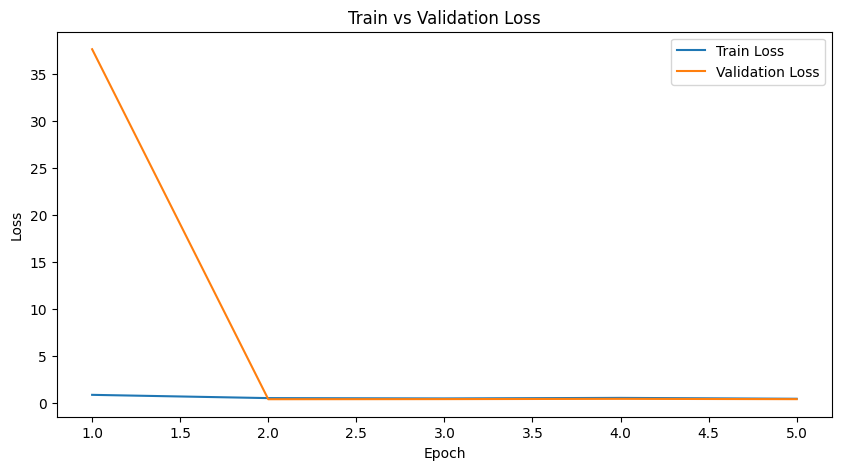

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(trainer.train_losses)+1), trainer.train_losses, label='Train Loss')
plt.plot(range(1, len(trainer.val_losses)+1), trainer.val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()
plt.show()

In [ ]:
evaluator = Food101Evaluator(trainer.model, test_loader, classes, trainer.device)
preds, labels = evaluator.evaluate()

Test Accuracy: 0.8784


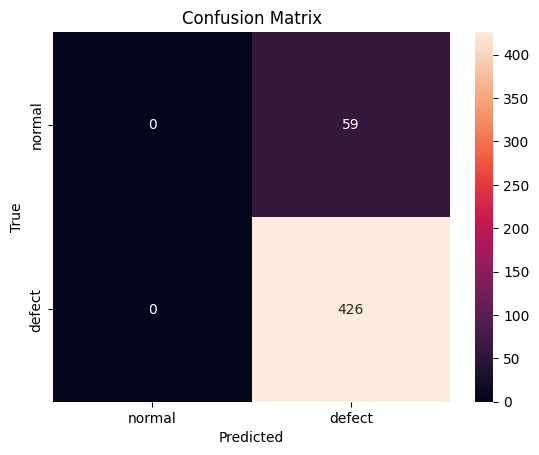

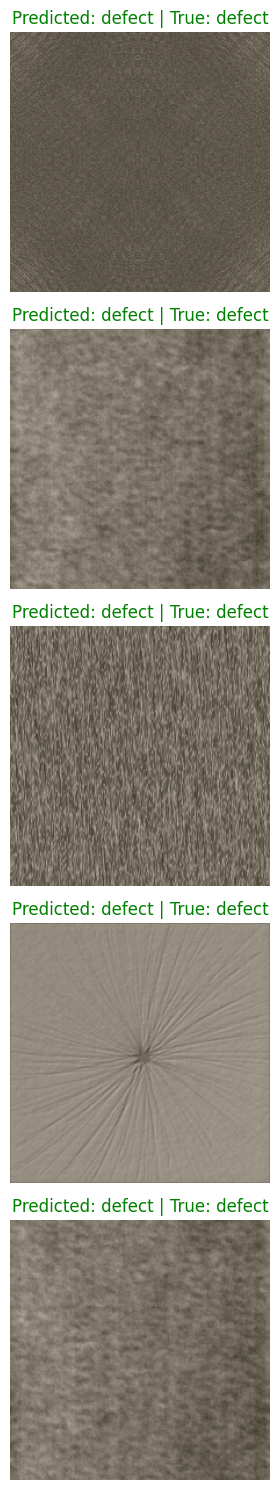

In [ ]:
visualizer = Food101Visualizer(classes)
visualizer.plot_confusion_matrix(labels, preds, selected_classes=['normal', 'defect'])
visualizer.plot_sample_predictions(trainer.model, test_loader.dataset, trainer.device)

### learning rate = 0.001

In [ ]:
# Trainer 내부에서 기록한 train_losses, val_losses 이용 (예시)
trainer = Food101ModelTrainer(train_loader, val_loader, classes, model_name='resnet18', lr=0.001, optimizer_type='adam')
trainer.train(epochs=5)  # 예시

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1: Train Loss=0.6286, Train Acc=0.8304, Val Loss=0.4641, Val Acc=0.8333
Epoch 2: Train Loss=0.3973, Train Acc=0.8696, Val Loss=0.4008, Val Acc=0.8708
Epoch 3: Train Loss=0.3981, Train Acc=0.8670, Val Loss=0.3968, Val Acc=0.8708
Epoch 4: Train Loss=0.4032, Train Acc=0.8678, Val Loss=0.4242, Val Acc=0.8708
Epoch 5: Train Loss=0.4055, Train Acc=0.8696, Val Loss=0.3866, Val Acc=0.8708


#### train, validation Loss 그래프

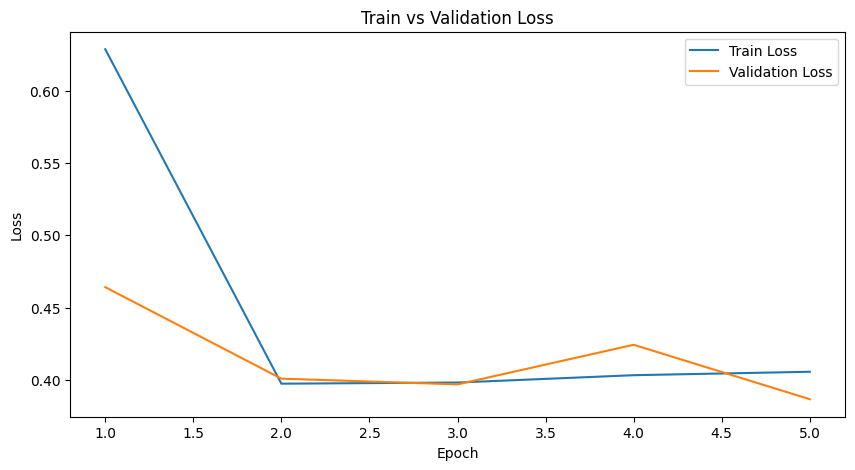

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(trainer.train_losses)+1), trainer.train_losses, label='Train Loss')
plt.plot(range(1, len(trainer.val_losses)+1), trainer.val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()
plt.show()

In [ ]:
evaluator = Food101Evaluator(trainer.model, test_loader, classes, trainer.device)
preds, labels = evaluator.evaluate()

Test Accuracy: 0.8784


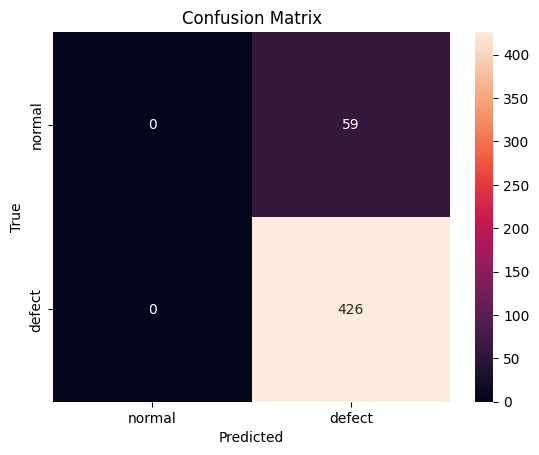

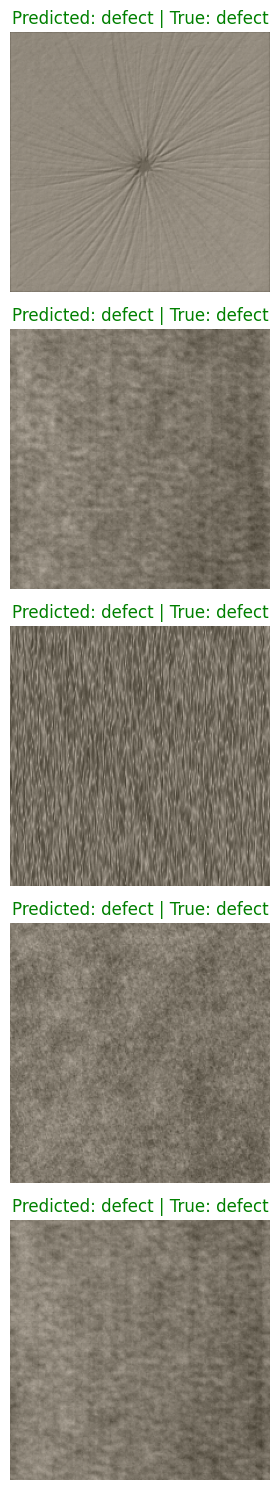

In [ ]:
visualizer = Food101Visualizer(classes)
visualizer.plot_confusion_matrix(labels, preds, selected_classes=['normal', 'defect'])
visualizer.plot_sample_predictions(trainer.model, test_loader.dataset, trainer.device)

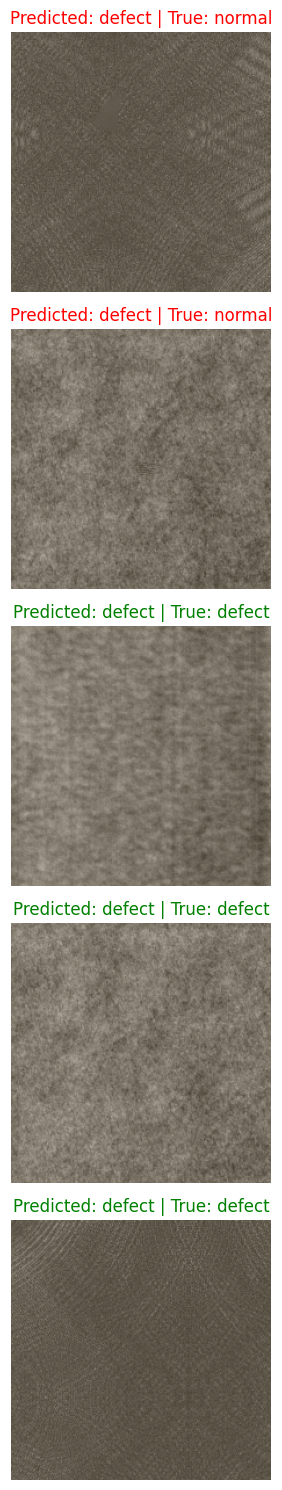

In [ ]:
visualizer.plot_sample_predictions(trainer.model, test_loader.dataset, trainer.device)

### learning rate = 0.0001, epoch = 20

In [ ]:
# Trainer 내부에서 기록한 train_losses, val_losses 이용 (예시)
trainer = Food101ModelTrainer(train_loader, val_loader, classes, model_name='resnet18', lr=0.0001, optimizer_type='adam')
trainer.train(epochs=20)  # 예시

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1: Train Loss=0.4334, Train Acc=0.8409, Val Loss=0.4383, Val Acc=0.8729
Epoch 2: Train Loss=0.2737, Train Acc=0.9043, Val Loss=0.2701, Val Acc=0.9000
Epoch 3: Train Loss=0.1666, Train Acc=0.9487, Val Loss=0.1948, Val Acc=0.9417
Epoch 4: Train Loss=0.1057, Train Acc=0.9661, Val Loss=0.1673, Val Acc=0.9396
Epoch 5: Train Loss=0.0495, Train Acc=0.9878, Val Loss=0.1407, Val Acc=0.9604
Epoch 6: Train Loss=0.0490, Train Acc=0.9817, Val Loss=0.1753, Val Acc=0.9563
Epoch 7: Train Loss=0.0446, Train Acc=0.9870, Val Loss=0.1722, Val Acc=0.9583
Epoch 8: Train Loss=0.0240, Train Acc=0.9957, Val Loss=0.1633, Val Acc=0.9625
Epoch 9: Train Loss=0.0201, Train Acc=0.9974, Val Loss=0.1710, Val Acc=0.9625
Epoch 10: Train Loss=0.0191, Train Acc=0.9939, Val Loss=0.1762, Val Acc=0.9646
Epoch 11: Train Loss=0.0115, Train Acc=0.9983, Val Loss=0.1394, Val Acc=0.9646
Epoch 12: Train Loss=0.0155, Train Acc=0.9948, Val Loss=0.2279, Val Acc=0.9542
Epoch 13: Train Loss=0.0286, Train Acc=0.9913, Val Loss=0.180

#### train, validation Loss 그래프

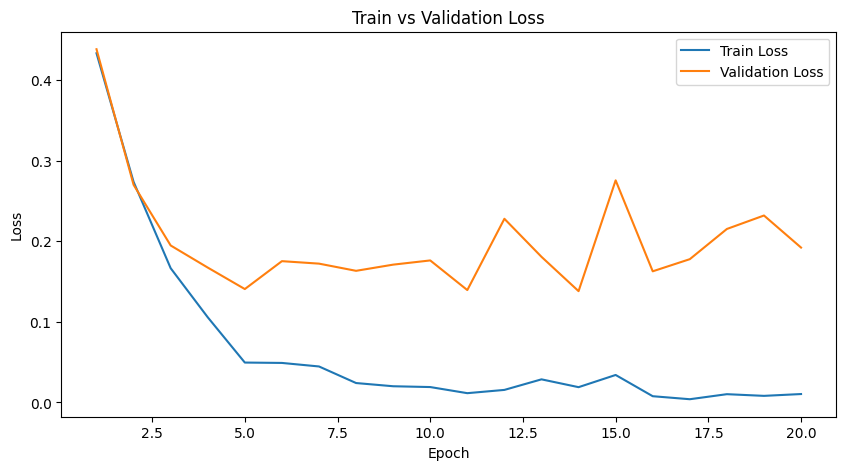

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(trainer.train_losses)+1), trainer.train_losses, label='Train Loss')
plt.plot(range(1, len(trainer.val_losses)+1), trainer.val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()
plt.show()

In [ ]:
evaluator = Food101Evaluator(trainer.model, test_loader, classes, trainer.device)
preds, labels = evaluator.evaluate()

Test Accuracy: 0.9670


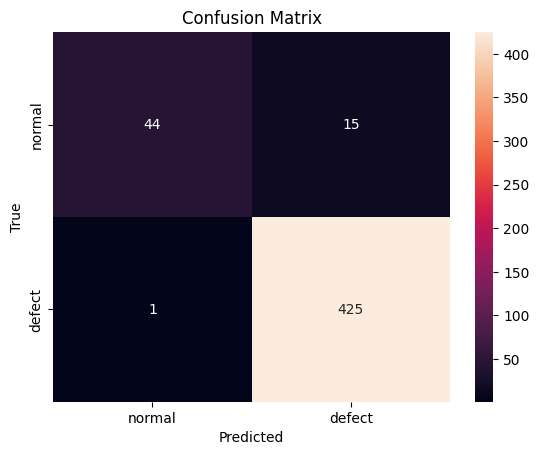

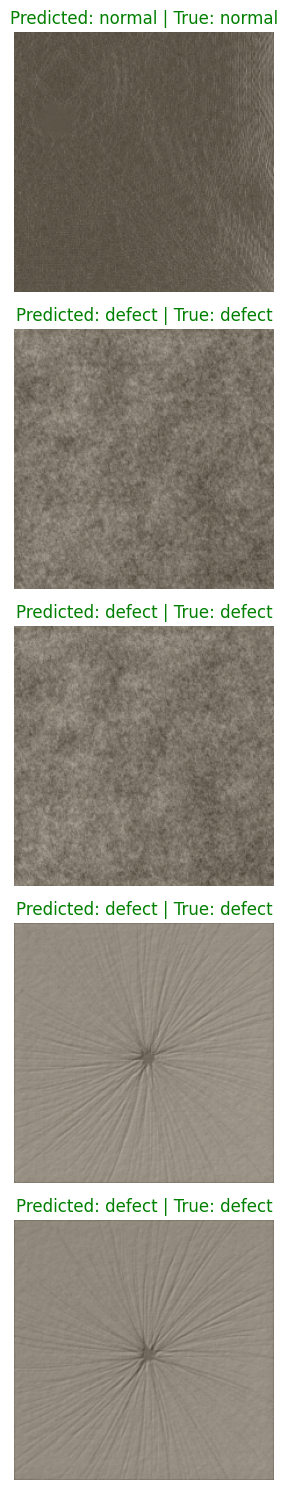

In [ ]:
visualizer = Food101Visualizer(classes)
visualizer.plot_confusion_matrix(labels, preds, selected_classes=['normal', 'defect'])
visualizer.plot_sample_predictions(trainer.model, test_loader.dataset, trainer.device)

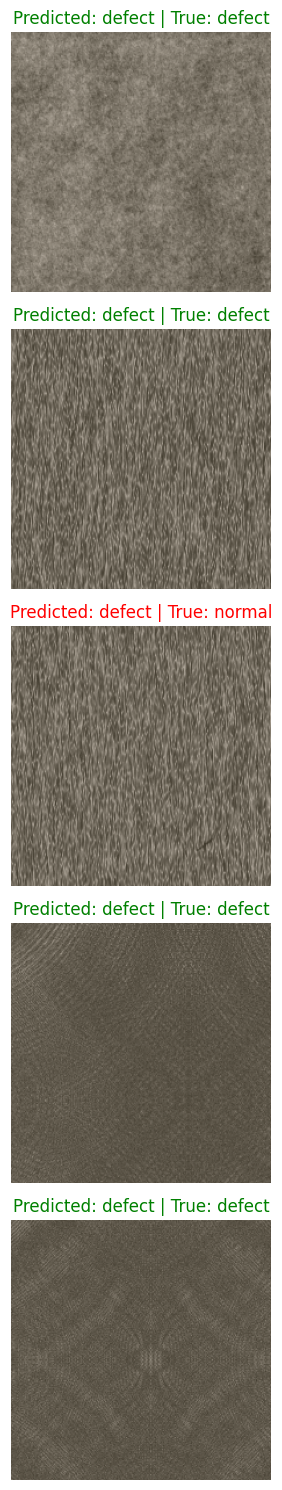

In [ ]:
visualizer.plot_sample_predictions(trainer.model, test_loader.dataset, trainer.device)

# Save Weight

## drive 연결

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## weight 저장

In [ ]:
torch.save(trainer.model.state_dict(), '/content/drive/MyDrive/Colab Notebooks/DAGM2007_resnet18_epoch20_lr0.0001.pth')

## weight 불러오기

In [ ]:
loaded_model = torch.load('/content/drive/MyDrive/Colab Notebooks/DAGM2007_resnet18_epoch20_lr0.0001.pth')
!cp /content/drive/MyDrive/Colab\ Notebooks/DAGM2007_resnet18_epoch20_lr0.0001.pth /content/DAGM2007_resnet18_epoch20_lr0.0001.pth